In [17]:
#VAMOS ANALISAR 6 AÇÕES DO MEU PORTFÓLIO, E COMO DEVO DISTRIBUI-LAS
import yfinance as yf

stocks = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'FLRY3.SA', 'SQIA3.SA', 'RADL3.SA']

data = yf.download(stocks, period='2y')

[*********************100%***********************]  6 of 6 completed


In [18]:
import numpy as np

closes = np.transpose(np.array(data.Close)) # Matriz do fechamento de preços diários
absdiff = np.diff(closes)                   # Mudança no fechamento de preços diários
reldiff = np.divide(absdiff, closes[:,:-1]) # mudança relativa no fechamento de preços
delta = np.mean(reldiff, axis=1)            # média do fechamento de preços
sigma = np.cov(reldiff)                     # covariancia (devios padrão)
std = np.std(reldiff, axis=1)               # desvio padrão

In [19]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Criar um modelo vazio
m = gp.Model('portfolio')

# Criar uma matriz para as açòes
x = m.addMVar(len(stocks))

# O objetivo é minimizar o risco (ao quadrado).  Isso é modelado usando
# a matriz de covariância, que mede a correlação histórica entre as ações
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fixar o orçamento com uma constante
m.addConstr(x.sum() == 1, 'budget')

# Verificar a formulação do modelo
m.write('portfolio_selection_optimization.lp')

# Otimizar o modelo para reduzir o risco
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0x2d60d76f
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-05, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.19599678e+05 -3.19599678e+05  4.50e+03 2.92e-07  1.00e+06     0s
   1   9.51308898e+03 -9.55025922e+03  2.93e+02 

In [20]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=stocks + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
PETR4.SA,0.209916
VALE3.SA,0.204855
ITUB4.SA,0.034913
FLRY3.SA,0.246547
SQIA3.SA,0.027875
RADL3.SA,0.275892
Volatility,0.012867
Expected Return,-0.000021


In [21]:
# Criar uma expressão representando o retorno esperado do portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Resolver para plotar uma fronteira de eficiência, variando os retornos
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target[0].rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xd9459e36
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [8e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-05, 2e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 6 columns, 12 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.100e+01
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.19578805e+05 -3.19578805e+05  4.50e+03 4.26e-03  1.00e+06     0s
   1   3.95132401e+03 -3.97850796e+03  2.17e+0

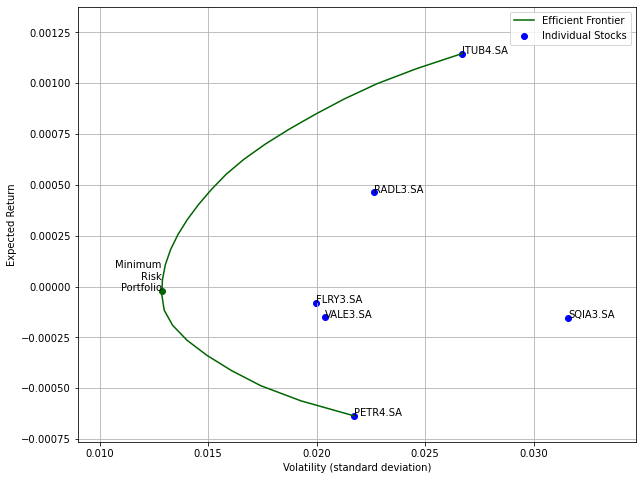

In [22]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plotar volatilidade x retorno esperado para cada ação
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))

# Plotar volatilidade x retorno esperado para o portfolio como um todo
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plotar a fronteira de eficiência
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Formatar e plotar a figura final
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()